# Description
## Objetive
This code predicts future value of index and share price.
Several visualisations for validating the result are also included.
<br>
## Process
The steps of optimization are as follows.
> -  1.Import necessary modules
> -  2.Ingest data from csv
> -  3.Transform datetime data to Python datetime
> -  4.Pivot the table and calculate return of each time series
> -  5.Calculate necessary parameters like average return, variance and co-variance
> -  6.Calculate returns, risk and sharpe rate in 250000 different portfolio allocation
> -  7.Visualise it and understand the best equity.
<br>
## References
__[facebook](https://research.fb.com/prophet-forecasting-at-scale/)__



In [1]:
import numpy as np
import scipy as sc
from fbprophet import Prophet
from fbprophet import diagnostics
import pandas as pd
import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: 

/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/scipy/optimize/_numdiff.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._group_columns import group_dense, group_sparse
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _stats
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/scipy/cluster/vq.py:78: RuntimeWarning: numpy.dtype size change

In [2]:
df = pd.read_csv('./portfolio_analysis.csv',header=0)
df_DJI=df[df['ticker']=='DJI']
df.describe()
df.info()
ticker_list=df.ticker.unique()
num_asset=df.ticker.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 3 columns):
date      15120 non-null object
ticker    15120 non-null object
price     15120 non-null float64
dtypes: float64(1), object(2)
memory usage: 354.4+ KB


In [3]:
#Check each ticker has the same date range
check1=df.groupby('ticker').date.nunique()
if check1.describe()['max']==check1.describe()['min']:
    print('no problem!')
else:
    print('each ticker needs to have the same time range')

    

no problem!


In [4]:
#Transform date value to python date
def datetime_transformation(df):
    for i in range(len(df)):
        try:
            df.iloc[i,0]=datetime.datetime.strptime(df.iloc[i,0],'%m/%d/%Y')
        except ValueError:
            df.iloc[i,0]=datetime.datetime.strptime(df.iloc[i,0],'%m/%d/%y')
    
    return df

        

In [5]:
df=datetime_transformation(df)
df_DJI=datetime_transformation(df_DJI)

/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
#Initialise portfolio to each asset and calculate returns
portfolio_dic=OrderedDict()
variance_dic=OrderedDict()
return_dic=OrderedDict()
cov_dic=OrderedDict()
finished_ticker=[]
for ticker in ticker_list:
    #print(ticker)
    portfolio_dic[ticker]= 1.0/num_asset
    variance_dic[ticker]=0
    return_dic[ticker]=0
    for d_ticker in ticker_list:
        if d_ticker == ticker or d_ticker in finished_ticker:
            pass
        else:
            d_ticker_n = ticker + '_' + d_ticker
            cov_dic[d_ticker_n] = 0
            finished_ticker.append(ticker)
    


In [7]:
df_pivot=df.pivot_table(index=['date'],columns=['ticker'],values=['price'])
df_pivot=df_pivot.sort_values('date')
#df_pivot.info()
#df_pivot.index=df_pivot['date']

In [8]:
#Transform daily price table to return table
df_return = df_pivot.copy()
for ticker_n in df_pivot.columns:
    if ticker_n == 'date':
        print('calc start')
    else:
        p_series=df_pivot[ticker_n]
        r_series=df_return[ticker_n]
        for i in range(len(df_pivot)-1):
            r_series[i+1] = float((p_series[i+1]-p_series[i]))/p_series[i]
        
        df_return[ticker_n]=r_series
            
df_return=df_return.iloc[1:,:]        
df_return.info()  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2010-07-01 to 2016-06-30
Data columns (total 10 columns):
(price, DJI)     1511 non-null float64
(price, app)     1511 non-null float64
(price, bidu)    1511 non-null float64
(price, dis)     1511 non-null float64
(price, goo)     1511 non-null float64
(price, msft)    1511 non-null float64
(price, tsla)    1511 non-null float64
(price, ttm)     1511 non-null float64
(price, wfc)     1511 non-null float64
(price, xom)     1511 non-null float64
dtypes: float64(10)
memory usage: 129.9 KB


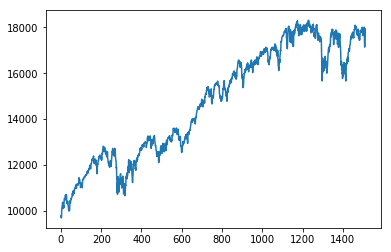

In [22]:

#df_return[('price','tsla')].plot()
#df_return[('price','tsla')].values
df_DJI['price'].plot()
#df_DJI.plot()
#type(df_return.index)

In [23]:
def prophet_prep(ts,y):
    df=pd.DataFrame(columns=['ds','y'])
    df['ds']=ts
    df['y']=y
    return df
    
def prophet_modelling(df,pred_term):
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=pred_term)
    forecast = model.predict(future)
    return model,forecast

def cal_mape(df):
    return((df['yhat'] - df['y']).div(df['y']).abs().sum()*(1/len(df)))


In [24]:
#df_prophet=prophet_prep(df_return.index,df_return[('price','DJI')].values)
df_prophet=prophet_prep(df_DJI['date'],df_DJI['price'])
model,forecast=prophet_modelling(df_prophet,365)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/dev-cory/.local/share/virtualenvs/portfolio_analysis-BYAa6zXe/local/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


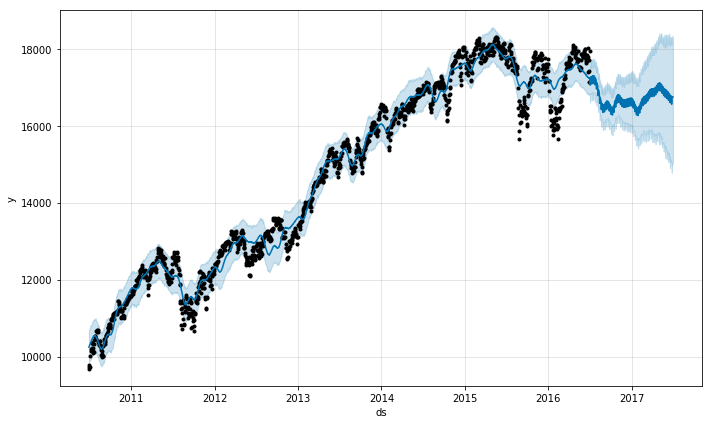

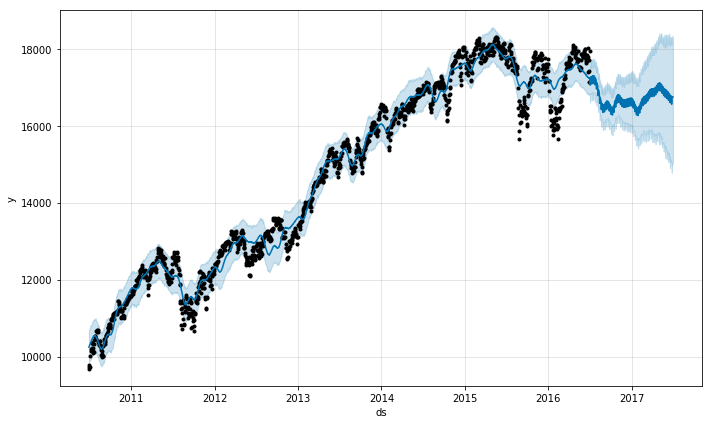

In [25]:
model.plot(forecast)

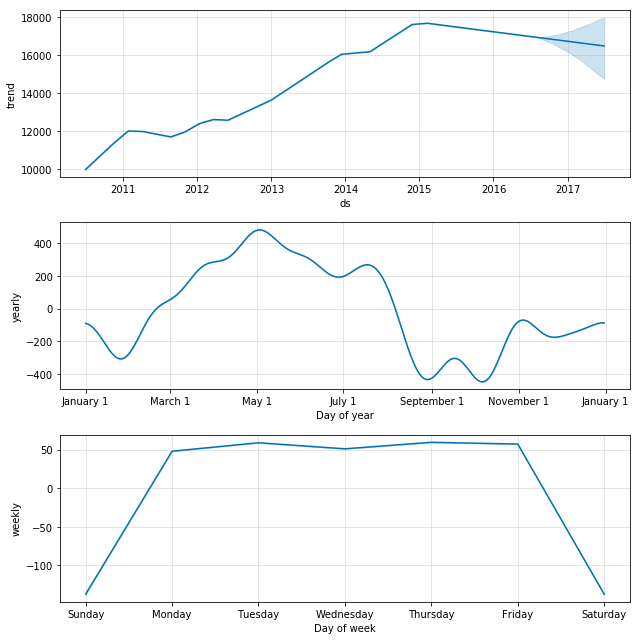

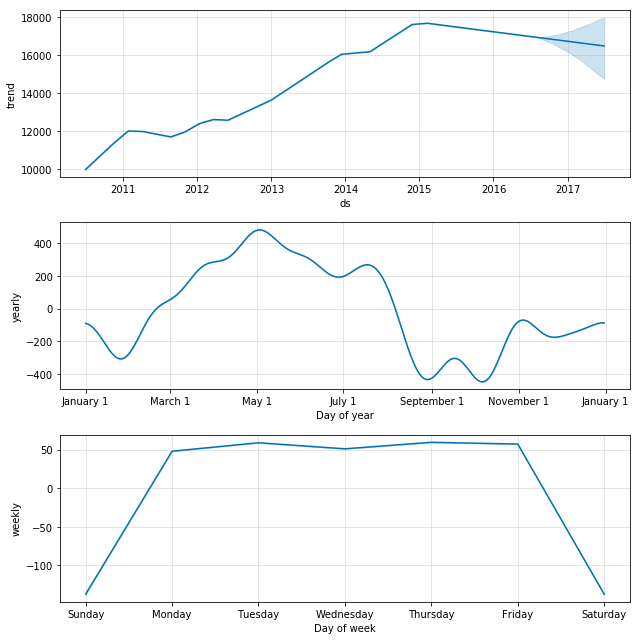

In [26]:
model.plot_components(forecast)

In [29]:
cv = diagnostics.cross_validation(model, horizon='365 days')

mape=float(cal_mape(cv))

print(mape)

INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2013-07-01 00:00:00 and 2015-07-01 00:00:00


0.0


In [45]:
#calculate average return and variance of single ticker 
for ticker in ticker_list:
    return_dic[ticker]=df_return[('price',ticker)].mean()
    variance_dic[ticker]=df_return[('price',ticker)].var()

print(return_dic.keys())
#print(variance_dic)
#print(return_dic.values())

['DJI', 'msft', 'wfc', 'xom', 'ttm', 'dis', 'goo', 'app', 'bidu', 'tsla']


In [ ]:
#Visualisation

